In [1]:
import os
import sys
import random
import time
from random import seed, randint
import argparse
import platform
from datetime import datetime
import imp
import numpy as np
import fileinput
from itertools import product
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
import seaborn as sns
from os import listdir

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib as mpl
# sys.path.insert(0,'..')
# from notebookFunctions import *
# from .. import notebookFunctions

from Bio.PDB.PDBParser import PDBParser
# sys.path.insert(0, '/Users/weilu/Research/opt_server/')
# from pyCodeLib import *
%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
# %matplotlib notebook
%load_ext autoreload
%autoreload 2

/Users/weilu/anaconda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv("/Users/weilu/Dropbox/gxxxg/proteins-2020-11-11.csv")

In [3]:
data.shape

(5546, 32)

In [4]:
data.columns

Index(['id', 'ordering', 'family_name_cache', 'species_name_cache',
       'membrane_name_cache', 'name', 'description', 'comments', 'pdbid',
       'resolution', 'topology_subunit', 'topology_show_in', 'thickness',
       'thicknesserror', 'subunit_segments', 'tilt', 'tilterror', 'gibbs',
       'tau', 'verification', 'membrane_id', 'species_id', 'family_id',
       'superfamily_id', 'classtype_id', 'type_id',
       'secondary_representations_count', 'structure_subunits_count',
       'citations_count', 'created_at', 'updated_at', 'uniprotcode'],
      dtype='object')

In [5]:
data.type_id.unique()

array([1, 2, 3])

In [6]:
# type 1 is transmembrane
# type 2 is monotopic/peripheral
# type 3 is peptides

In [7]:
# We focus on transmembrane protein
data = data.query("type_id == 1").reset_index(drop=True)

In [8]:
data.shape

(3299, 32)

In [9]:
# Alpha-helical polytopic (130 superfamilies)
# Bitopic proteins (66 superfamilies)
# Beta-barrel transmembrane (35 superfamilies)
# All alpha monotopic/peripheral (65 superfamilies)
# All beta monotopic/peripheral (60 superfamilies)
# Alpha/Beta monotopic/peripheral (34 superfamilies)
# Alpha + Beta monotopic/peripheral (42 superfamilies)
# Alpha-helical peptides (39 superfamilies)
# Beta-hairpin peptides (13 superfamilies)
# Beta-helical peptides (2 superfamilies)
# Peptides of nonregular structure (12 superfamilies)
## classes

In [10]:
data.classtype_id.unique()

array([ 2, 11,  1])

In [11]:
# we only work with alpha-helical polytopic protein
data = data.query("classtype_id == 1").reset_index(drop=True)

In [59]:
data.family_name_cache.value_counts().head(10)

G-protein coupled receptors, family A                     228
V-type and F-type ATPases                                 108
Transient receptor potential channels                     104
P-ATPase                                                   91
H+ or Na+ translocating NADH dehydrogenase                 69
Glutamate-gated Ion Channel (GIC) family                   68
Microbial and algal rhodopsins                             56
Ligand-gated ion channel of neurotransmitter receptors     52
Cytochrome bc1 and b6f complexes                           43
Voltage-sensitive Nav channel-like family                  42
Name: family_name_cache, dtype: int64

In [12]:
data.shape

(2484, 32)

In [13]:
data.structure_subunits_count.unique()

array([ 2,  1,  9,  7,  5,  4,  3, 18, 16,  6, 13, 11, 10, 20, 12, 22,  0,
       15, 14, 26, 31, 32, 34, 42,  8, 21, 48, 17, 24, 53, 35, 30, 36, 44,
       46, 52, 19, 27, 51])

In [14]:
# strange cases
data.query("structure_subunits_count == 0")

,id,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,...,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at,uniprotcode
118,612,2210.0,Peptidase S26,Escherichia coli,Gram-neg. inner,"Type 1 signal peptidase, complex with lipopep...",NaN,Consistent with membrane binding mode proposed...,"=""1t7d""",2.47,...,100,137,1,1,0,0,1,2018-08-13 03:50:35 UTC,2020-05-10 22:00:37 UTC,LEP_ECOLI
120,622,2209.0,Peptidase S26,Escherichia coli,Gram-neg. inner,"Type 1 signal peptidase, complex with inhibitor",NaN,Consistent with membrane binding mode proposed...,"=""1b12""",1.95,...,100,137,1,1,0,0,1,2018-08-13 03:50:36 UTC,2020-05-13 20:43:47 UTC,LEP_ECOLI
121,625,2208.0,Peptidase S26,Escherichia coli,Gram-neg. inner,"Type 1 signal peptidase, apo-enzyme",NaN,Function - see review by Paetzel et al. (2002).,"=""1kn9""",2.4,...,100,137,1,1,0,0,6,2018-08-13 03:50:36 UTC,2020-05-11 00:14:15 UTC,LEP_ECOLI
130,684,2187.0,ClpP protease,Pyrococcus horikoshii,Archaebac.,Membrane protease specific for a stomatin homo...,NaN,NaN,"=""3bpp""",2.3,...,233,86,1,1,1,0,1,2018-08-13 03:50:41 UTC,2020-05-10 22:00:42 UTC,STOPP_PYRHO
137,728,296.0,GPCR Secretin (B) family,Drosophila melanogaster,Eykaryo. plasma,Ectodomain of G-protein coupled receptor Mth,NaN,NaN,"=""1fjr""",2.3,...,242,6,1,1,0,0,0,2018-08-13 03:50:44 UTC,2020-05-11 00:14:16 UTC,MTH_DROME
193,875,2381.0,FtsH zinc metalloprotease,Thermotoga maritima,Gram-neg. inner,ATP-dependent zinc metalloprotease FtsH,NaN,NaN,"=""3kds""",2.6,...,494,471,1,1,2,0,0,2018-08-13 03:50:55 UTC,2020-05-10 22:01:27 UTC,FTSH_THEMA
200,901,1974.0,OxaA/YidC,Escherichia coli,Gram-neg. inner,"Membrane protein insertase YidC, periplasmic d...",NaN,NaN,"=""3blc""",2.5,...,293,202,1,1,1,0,0,2018-08-13 03:50:56 UTC,2020-05-10 22:01:32 UTC,YIDC_ECOLI
238,1006,2247.0,Type IV secretory system,Helicobacter pylori,Gram-neg. outer,TrbI protein,NaN,Homolog of TraF/VirB10,"=""2bhv""",3.0,...,319,215,1,1,0,0,0,2018-08-13 03:51:08 UTC,2020-05-13 20:44:52 UTC,O24883_HELPY
284,1208,2167.0,Sulfatase,Bacillus subtilis,Gram-pos. inner,Glycerol phosphate lipoteichoic acid synthase 2,NaN,This is extracellular domain of transmembrane ...,"=""2w8d""",2.35,...,32,24,1,1,0,0,0,2018-08-13 03:51:30 UTC,2020-05-10 22:02:13 UTC,LTAS2_BACSU
285,1209,2166.0,Sulfatase,Staphylococcus aureus,Gram-pos. inner,Glycerol phosphate lipoteichoic acid synthase,NaN,This is extracellular domain of transmembrane ...,"=""2w5q""",1.2,...,32,24,1,1,3,0,0,2018-08-13 03:51:30 UTC,2020-05-10 22:02:14 UTC,LTAS_STAAW


In [15]:
# we only work with Monomer for now.
d1 = data.query("structure_subunits_count == 1").reset_index(drop=True)

In [58]:
d1.family_name_cache.value_counts().sum()

754

In [56]:
d1.family_name_cache.value_counts().head(10)

G-protein coupled receptors, family A              209
P-ATPase                                            50
GPCR Secretin (B) family                            36
Multidrug resistance exporter (MDR)                 28
Proton-dependent oligopeptide transporter (POT)     21
Patched family                                      19
Multi antimicrobial extrusion (MATE) family         18
Microbial and algal rhodopsins                      17
Sugar porter family                                 15
Frizzled/Smoothened family                          15
Name: family_name_cache, dtype: int64

In [16]:
d1.shape

(754, 32)

In [17]:
# remove NMR structures.
d1["resolution"] = d1["resolution"].fillna("NMR")
d2 = d1.query("resolution != 'NMR' and thickness < 100").reset_index(drop=True)

In [18]:
d2.shape

(705, 32)

In [82]:
d2.to_csv("/Users/weilu/Dropbox/gxxxg/curated_membrane_protein_target_set_curation.csv")

In [75]:
os.system("mkdir -p /Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/original")

0

In [76]:
# move those pdbs to a folder
for pdb in d2["pdbid"]:
    # print(pdb)
    pdbName = pdb[2:6]
    # print(pdbName)
    os.system(f"cp /Users/weilu/Downloads/Alpha-helical_polytopic/{pdbName}.pdb /Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/original/")

In [86]:
os.system("mkdir -p /Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/membrane_part")
for pdb in d2["pdbid"]:
    # print(pdb)
    pdbName = pdb[2:6]
    os.system(f"python ~/opt/small_script/extract_membrane_part.py /Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/original/{pdbName}.pdb /Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/membrane_part/{pdbName}.pdb -c 17")


In [19]:
d2.resolution.unique()

array(['2.8', '3.3', '2.0', '1.9', '3.4', '2.2', '2.65', '2.5', '2.3',
       '2.6', '2.4', '3.45', '2.1', '1.8', '3.2', '2.78', '3.6', '2.45',
       '2.91', '2.9', '2.95', '3.02', '3.5', '4.15', '3.7', '2.85', '3.1',
       '3.8', '2.32', '4.19', '3.14', '2.09', '3.65', '2.89', '3.62',
       '2.79', '2.29', '2.71', '1.7', '3.0', '3.22', '3.99', '2.7',
       '3.19', '3.27', '3.01', '3.49', '6.0 EM', '2.55', '3.38', '4.2',
       '2.98', '4.0', '4.1', '3.15', '2.35', '1.95', '2.75', '2.49',
       '3.35', '3.58', '3.61', '2.61', '3.56', '2.62', '3.21', '2.33',
       '3.51', '2.74', '1.96', '3.28', '1.6', '3.78', '3.25', '1.45',
       '1.52', '2.83', '2.94', '2.58', '3.18', '1.58', '3.94', '4.01',
       '3.73 EM', '4.5 EM', '2.81', '3.87 EM', '3.49 EM', '3.34 EM',
       '1.79', '3.8 EM', '2.73', '4.1 EM', '2.05', '2.14', '2.59',
       '3.37 EM', '3.31', '3.9', '3.34', '1.48', '2.37', '1.77', '2.41',
       '1.83', '3.14 EM', '2.44', '3.4 EM', '2.87', '3.58 EM', '4.14 EM',
       

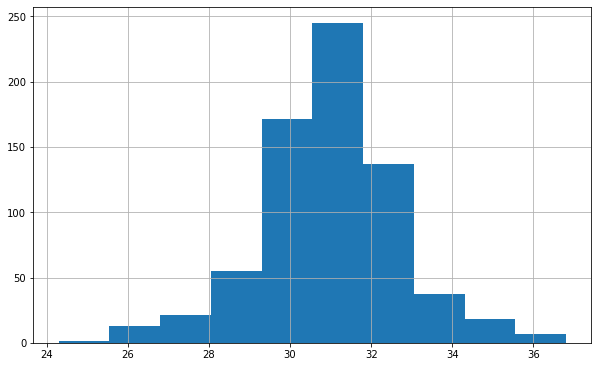

In [20]:
d2.query("thickness < 100").thickness.hist()

In [22]:
pdb_list = d2["pdbid"].to_list()
pdb_list = [pdb[2:6] for pdb in pdb_list]

In [23]:
remove_pdb_list = []
for pdb in pdb_list:
    x = PDBParser(QUIET=True).get_structure("x", f"/Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/membrane_part/{pdb}.pdb")
    n_chain = len(list(x.get_chains()))
    if n_chain != 1:
        print(pdb)
        remove_pdb_list.append(pdb)

3wbn
4grv
4iky
4buo
3wmg
4tpj
4qo2
4rwa
4rws
4xt3
4xt1
4q9l
4q9i
4q9j
4xtl
4zwj
4xes
5glh
5t04
5vai
5vbl
5uiw
5nx2
5yqz
6b3j
6c1r
5wb2
6ddf
5xjm
6a90
5oxl
4rwd
5oxk
6igk
6igl
6fj3
6meo
6niy
6do1
6nt4
6i6h
6r7z
6nbf
6nbh
6nbi
6ot0
6os9
6osa
6qno
6oya
6pza
6kg7
6pj4
6pt2
6ukj
6pwc
6orv
6jod
6ryo
6knm
6p9x
6p9y
6kpf
6pt0
6kpg
6lry
6pb0
6pb1
6os0
6os2
6up7
6omm
6u1n
6lpb
6m1h
6m1i
6lw5
6lmk
6lml
6k42
6vjy
6vk1
6w25
6whc
6vcb
7c6a
6wi9
6wpw
6wzg
6x18
6x19
7c2e
6wbv
6xbj
6xbl
6xbm


In [24]:
len(remove_pdb_list)

96

In [25]:
d2["pdb"] = pdb_list

In [26]:
d3 = d2.query("pdb not in @remove_pdb_list").reset_index(drop=True)

In [114]:
d3.to_csv("/Users/weilu/Dropbox/gxxxg/curated_d3.csv")

In [27]:
pdb_list = d3["pdb"].to_list()
info = []
for pdb in pdb_list:
    x = PDBParser(QUIET=True).get_structure("x", f"/Users/weilu/Dropbox/gxxxg/membrane_protein_target_set_curation/cleaned_membrane_part/{pdb}.pdb")
    # n_chain = len(list(x.get_chains()))
    n_res = len(list(x.get_residues()))
    info.append([pdb, n_res])
info = pd.DataFrame(info, columns=["Protein", "Length"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87e7a384e0>]],
      dtype=object)

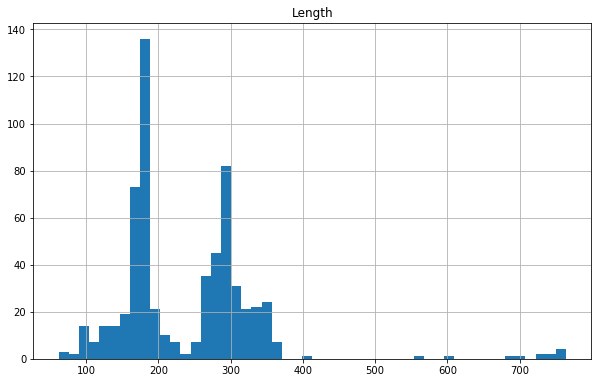

In [28]:
info.hist("Length", bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87e88fd550>]],
      dtype=object)

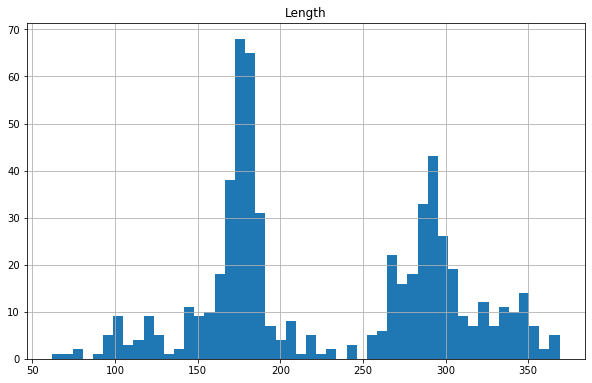

In [29]:
info.query("Length < 400").hist("Length", bins=50)

In [30]:
outside_range = info.query("Length < 150 or Length > 400")["Protein"].to_list()

In [31]:
d4 = d3.query("pdb not in @outside_range").reset_index(drop=True)

In [32]:
d4 = d4.merge(info, left_on="pdb", right_on="Protein")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87e6d224a8>]],
      dtype=object)

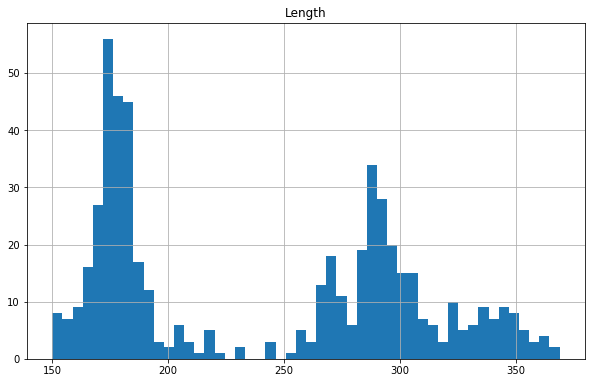

In [33]:
d4.hist("Length", bins=50)

In [34]:
d4["Resolution"] = d4.resolution.apply(lambda x:float(x.split()[0]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f87e6d3cf98>]],
      dtype=object)

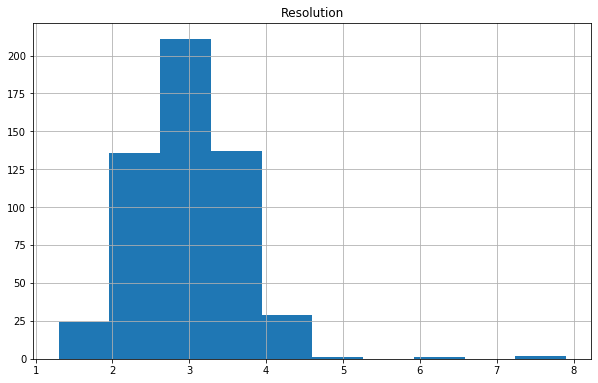

In [35]:
d4.hist("Resolution")

In [36]:
d5 = d4.query("Resolution < 4.5").reset_index(drop=True)

In [37]:
d5.shape

(534, 36)

In [38]:
pd.set_option('display.max_columns', 100)

In [39]:
d5.sample(20, random_state=0).head(8)

,id,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,topology_subunit,topology_show_in,thickness,thicknesserror,subunit_segments,tilt,tilterror,gibbs,tau,verification,membrane_id,species_id,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at,uniprotcode,pdb,Protein,Length,Resolution
172,2754,1775.0,Proton-dependent oligopeptide transporter (POT),Shewanella oneidensis,Gram-neg. inner,"Glutathione uptake transporter, structure 2",NaN,NaN,"=""4uvm""",3.0,A,True,29.8,0.7,14,10,0,-105.3,NaN,NaN,2,319,333,15,1,1,0,1,0,2018-08-13 03:54:18 UTC,2020-05-10 22:06:54 UTC,Q8EKT7_SHEON,4uvm,4uvm,342,3.00
464,5079,874.0,Multidrug resistance exporter (MDR),Homo sapiens,Eykaryo. plasma,Bile salt export pump ABCB11,NaN,NaN,"=""6lr0""",3.5 EM,A,True,31.0,1.0,12,3,0,-78.8,NaN,NaN,4,14,278,17,1,1,0,1,0,2020-04-26 23:37:39 UTC,2020-05-15 17:39:56 UTC,ABCBB_HUMAN,6lr0,6lr0,310,3.50
196,2976,723.0,P-ATPase,Oryctolagus cuniculus,Endoplasm. reticulum,"Calcium ATPase, E1 state, with macrolide BLS",NaN,NaN,"=""4ycm""",3.2,A,True,30.8,1.2,10,24,3,-67.5,NaN,NaN,6,25,30,22,1,1,1,1,0,2018-08-13 03:54:31 UTC,2020-05-10 22:07:29 UTC,AT2A1_RABIT,4ycm,4ycm,261,3.20
414,4623,1809.0,Spinster protein family,Hyphomonas neptunium,Gram-neg. inner,Bacterial homolog of protein Spinster,NaN,NaN,"=""6e9c""",3.2,A,True,31.4,1.0,12,9,2,-98.0,NaN,NaN,2,843,1009,15,1,1,2,1,0,2019-09-08 15:26:33 UTC,2020-05-10 22:13:24 UTC,Q0C3L7_HYPNA,6e9c,6e9c,285,3.20
530,5579,883.0,Multidrug resistance exporter (MDR),Homo sapiens,Eykaryo. plasma,"P-glycoprotein, human, structure 7",NaN,NaN,"=""7a6e""",3.6 EM,A,True,31.4,0.6,12,5,2,-83.4,NaN,NaN,4,14,278,17,1,1,0,1,0,2020-10-27 22:04:32 UTC,2020-11-01 01:33:12 UTC,MDR1_HUMAN,7a6e,7a6e,290,3.60
210,3102,335.0,Frizzled/Smoothened family,Homo sapiens,Eykaryo. plasma,"Smoothened homolog, inactive state, structure 4",NaN,NaN,"=""5l7i""",3.3,A,False,32.4,1.4,7,10,1,-58.7,NaN,NaN,4,14,667,6,1,1,0,1,0,2018-08-13 03:54:40 UTC,2020-05-10 22:07:51 UTC,C562_ECOLX SMO_HUMAN,5l7i,5l7i,187,3.30
485,5256,137.0,"G-protein coupled receptors, family A",Homo sapiens,Eykaryo. plasma,"Chemokine receptor CCR6, with G-protein and ch...",NaN,NaN,"=""6wwz""",3.34 EM,R,False,33.8,0.8,7,3,2,-83.1,NaN,NaN,4,14,14,6,1,1,0,1,0,2020-07-19 16:41:00 UTC,2020-09-01 01:22:21 UTC,C562_ECOLX CCL20_HUMAN CCR6_HUMAN GBB1_RAT GBG...,6wwz,6wwz,165,3.34
236,3344,2306.0,Transmembrane lipid phosphatase,Bacillus subtilis,Gram-pos. inner,Phosphatidylglycerol phosphate phosphatase,NaN,NaN,"=""6fmx""",1.79,A,True,25.8,1.0,6,42,1,-59.2,NaN,NaN,8,89,704,409,1,1,1,1,0,2018-08-13 03:54:56 UTC,2020-05-11 00:17:28 UTC,PGPB_BACSU,6fmx,6fmx,181,1.79


In [40]:
d5.sample(20, random_state=0).head(8)[["pdb", "family_name_cache"]]

,pdb,family_name_cache
172,4uvm,Proton-dependent oligopeptide transporter (POT)
464,6lr0,Multidrug resistance exporter (MDR)
196,4ycm,P-ATPase
414,6e9c,Spinster protein family
530,7a6e,Multidrug resistance exporter (MDR)
210,5l7i,Frizzled/Smoothened family
485,6wwz,"G-protein coupled receptors, family A"
236,6fmx,Transmembrane lipid phosphatase


In [41]:
d5.query("pdb == '1gzm'")

,id,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,topology_subunit,topology_show_in,thickness,thicknesserror,subunit_segments,tilt,tilterror,gibbs,tau,verification,membrane_id,species_id,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at,uniprotcode,pdb,Protein,Length,Resolution
5,93,255.0,"G-protein coupled receptors, family A",Bos taurus,Eykaryo. plasma,"Rhodopsin, inactive, with 11-cis retinal",NaN,Structures of intermediate states: bathorhodop...,"=""1gzm""",2.65,A,False,32.2,1.5,7,11,1,-75.6,18,Results are consitent with X-ray scattering (...,4,6,14,6,1,1,4,1,6,2018-08-13 03:49:53 UTC,2020-05-11 00:13:43 UTC,OPSD_BOVIN,1gzm,1gzm,190,2.65


In [42]:
d5.columns

Index(['id', 'ordering', 'family_name_cache', 'species_name_cache',
       'membrane_name_cache', 'name', 'description', 'comments', 'pdbid',
       'resolution', 'topology_subunit', 'topology_show_in', 'thickness',
       'thicknesserror', 'subunit_segments', 'tilt', 'tilterror', 'gibbs',
       'tau', 'verification', 'membrane_id', 'species_id', 'family_id',
       'superfamily_id', 'classtype_id', 'type_id',
       'secondary_representations_count', 'structure_subunits_count',
       'citations_count', 'created_at', 'updated_at', 'uniprotcode', 'pdb',
       'Protein', 'Length', 'Resolution'],
      dtype='object')

In [43]:
superfamily = pd.read_csv("/Users/weilu/Dropbox/gxxxg/superfamilies-2020-11-11.csv")

In [44]:
superfamily["superfamily_name"] = superfamily["name"]

In [45]:
d6 = d5.merge(superfamily[["id", "superfamily_name"]], left_on="superfamily_id", right_on="id")

In [46]:
d6.family_id.value_counts().shape

(89,)

In [47]:
d6.family_id.value_counts().head()

14     162
30      49
278     23
327     17
812     17
Name: family_id, dtype: int64

In [48]:
d6.family_name_cache.value_counts().head(30)

G-protein coupled receptors, family A              162
P-ATPase                                            49
Multidrug resistance exporter (MDR)                 23
Proton-dependent oligopeptide transporter (POT)     17
Multi antimicrobial extrusion (MATE) family         17
Patched family                                      17
Microbial and algal rhodopsins                      15
Sugar porter family                                 15
Neurotransmitter: sodium symporter                  12
Drug conjugate transporter (ABC C family)           12
Frizzled/Smoothened family                          11
Glycerol-3-phosphate transporter                    10
Drug/proton antiporter                               9
GPCR Secretin (B) family                             9
Divalent metal ion transporter (NRAMP)               8
LacY-like proton/sugar symporter                     8
Rhomboid proteases                                   7
Glycerol-3-phosphate acyltransferase                 5
Carbon-nit

In [80]:
a = d6.family_id.value_counts().head(20)

In [84]:
selected_family = a.index.to_list()[:12]

In [85]:
chosen_list = d6.query("family_id in @selected_family").groupby("family_id").sample(n=1, random_state=0)

In [67]:
chosen_list.to_csv("/Users/weilu/Dropbox/gxxxg/chosen_one_from_each_family")

In [70]:
chosen_list = pd.read_csv("/Users/weilu/Dropbox/gxxxg/chosen_one_from_each_family", index_col=0)
pdb_list = chosen_list["pdb"].to_list()
for pdb in pdb_list:
    do("cp ../cleaned_membrane_part/1uaz.pdb 1uaz_cleaned.pdb")
    do("cp ../original/1uaz.pdb 1uaz_original.pdb")

In [73]:
print(chosen_list["pdb"].to_list())

['1uaz', '5lwe', '6e9o', '5ncq', '5i6x', '6fn1', '3vvo', '4tph', '6m20', '6d32', '6tbu', '5uak']


In [ ]:
manual_chosen = ['1uaz', '5lwe', '6e9o', '5i6x', '3vvo', '4tph', '6m20', '6d32', '6tbu']

In [72]:
chosen_list

,id_x,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,topology_subunit,topology_show_in,thickness,thicknesserror,subunit_segments,tilt,tilterror,gibbs,tau,verification,membrane_id,species_id,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at,uniprotcode,pdb,Protein,Length,Resolution,id_y,superfamily_name
72,77,1.0,Microbial and algal rhodopsins,Halobacterium sp.,Archaebac.,Archaerhodopsin-1,NaN,Light-driven proton pump. It may interact with...,"=""1uaz""",3.4,A,False,31.8,1.3,7,9,2,-65.3,35.0,NaN,1,13,13,6,1,1,0,1,0,2018-08-13 03:49:52 UTC,2020-05-10 21:56:22 UTC,BACR1_HALC1,1uaz,1uaz,171,3.40,6,Rhodopsin-like receptors and pumps
146,3278,136.0,"G-protein coupled receptors, family A",Homo sapiens,Eykaryo. plasma,"C-C chemokine receptor type 9, inactive state",NaN,NaN,"=""5lwe""",2.8,A,False,33.0,1.8,7,7,0,-75.8,NaN,NaN,4,14,14,6,1,1,0,1,0,2018-08-13 03:54:53 UTC,2020-05-10 22:08:24 UTC,CCR9_HUMAN,5lwe,5lwe,170,2.80,6,Rhodopsin-like receptors and pumps
52,4533,1732.0,Glycerol-3-phosphate transporter,Escherichia coli,Gram-neg. inner,"D-galactonate transporter dgoT, outward substr...",NaN,NaN,"=""6e9o""",3.5,A,True,29.8,1.0,12,2,0,-87.0,NaN,NaN,2,9,23,15,1,1,0,1,0,2019-07-13 14:13:07 UTC,2020-05-10 22:12:49 UTC,J7QAK3_ECOLX,6e9o,6e9o,281,3.50,15,Major Facilitator Superfamily (MFS)
309,3653,734.0,P-ATPase,Oryctolagus cuniculus,Endoplasm. reticulum,"Calcium ATPase, E2 state (Ca-free), conformati...",NaN,NaN,"=""5ncq""",3.0,A,True,30.2,1.2,10,26,0,-69.3,NaN,NaN,6,25,30,22,1,1,0,1,0,2018-08-13 03:55:09 UTC,2020-05-10 22:09:37 UTC,AT2A1_RABIT,5ncq,5ncq,269,3.00,22,P-type ATPase (P-ATPase)
343,3049,1827.0,Neurotransmitter: sodium symporter,Homo sapiens,Eykaryo. plasma,"Serotonin transporter, outward-facing, structu...",NaN,NaN,"=""5i6x""",3.14,A,True,31.6,1.4,12,10,0,-90.7,NaN,NaN,4,14,78,64,1,1,11,1,0,2018-08-13 03:54:37 UTC,2020-05-11 00:17:14 UTC,SC6A4_HUMAN,5i6x,5i6x,342,3.14,64,APC (Amino acid-Polyamine-organoCation) superf...
413,3710,877.0,Multidrug resistance exporter (MDR),Homo sapiens,Eykaryo. plasma,"P-glycoprotein, human, structure 1",NaN,NaN,"=""6fn1""",3.58 EM,A,True,31.0,0.8,12,9,0,-89.8,NaN,NaN,4,14,278,17,1,1,0,1,0,2018-08-13 03:55:11 UTC,2020-10-29 02:05:47 UTC,MDR1_HUMAN,6fn1,6fn1,301,3.58,17,ABC transporters
365,451,2052.0,Multi antimicrobial extrusion (MATE) family,Pyrococcus furiosus,Archaebac.,"H+-driven MATE exporter, outward-open, ""bent"" ...",NaN,NaN,"=""3vvo""",2.5,A,True,31.4,1.1,12,11,0,-93.1,NaN,NaN,1,305,327,220,1,1,0,1,0,2018-08-13 03:50:16 UTC,2020-05-10 21:57:50 UTC,Q8U2X0_PYRFU,3vvo,3vvo,305,2.50,220,Multidrug/Oligosaccharidyl-lipid superfamily
29,2488,1760.0,Proton-dependent oligopeptide transporter (POT),Shewanella oneidensis,Gram-neg. inner,"Bacterial proton:oligopeptide symporter, struc...",NaN,NaN,"=""4tph""",3.15,A,True,30.6,0.6,14,9,0,-96.5,NaN,NaN,2,319,333,15,1,1,1,1,0,2018-08-13 03:53:59 UTC,2020-05-10 22:06:18 UTC,Q8EHE6_SHEON,4tph,4tph,349,3.15,15,Major Facilitator Superfamily (MFS)
68,5489,1794.0,Sugar porter family,Plasmodium falciparum,Eykaryo. plasma,"Hexose transporter 1, structure 2",NaN,NaN,"=""6m20""",2.6,A,True,32.6,1.8,12,1,0,-108.4,NaN,NaN,4,249,656,15,1,1,0,1,0,2020-10-27 22:04:32 UTC,2020-10-28 04:07:57 UTC,O97467_PLAFA,6m20,6m20,286,2.60,15,Major Facilitator Superfamily (MFS)
179,3872,343.0,Frizzled/Smoothened family,Xenopus laevis,Eykaryo. plasma,"Smoothened receptor, inactive state",NaN,NaN,"=""6d32""",3.75,A,False,31.8,1.4,7,12,1,-63.0,NaN,NaN,4,55,667,6,1,1,1,1,0,2018-08-13 03:55:17 UTC,2020-05-10 22:10:18 UTC,A0A1L8GTP2_XENLA C562_ECOLX,6d32,6d32,183,3.75,6,Rhodopsin-like receptors and pumps


In [185]:
d6.superfamily_name.value_counts()

Rhodopsin-like receptors and pumps                                203
Major Facilitator Superfamily (MFS)                                71
P-type ATPase (P-ATPase)                                           49
ABC transporters                                                   37
APC (Amino acid-Polyamine-organoCation) superfamily                33
Resistance-nodulation-cell division                                25
Multidrug/Oligosaccharidyl-lipid superfamily                       22
Glycosyl transferase GT-C superfamily                               9
Rhomboid protease                                                   7
Glycerol-3-phosphate acyltransferase                                5
Carbon-nitrogen hydrolase                                           5
Sodium/calcium exchanger                                            5
Energy-coupling factor transporters                                 5
Mitochondrial Carrier (MC)                                          5
Monovalent cation-pr

In [87]:
additional_selected_family = a.index.to_list()[12:20]

In [88]:
additional_chosen_list = d6.query("family_id in @additional_selected_family").groupby("family_id").sample(n=1, random_state=0)

In [89]:
print(additional_chosen_list["pdb"].to_list())

['4c9g', '4oaa', '6gv1', '2nrf', '4z9g', '6bu5', '5t77', '6nwr']


In [174]:
d5.superfamily_id.value_counts()

6      203
15      71
22      49
17      37
64      33
16      25
220     22
242      9
165      7
134      5
474      5
466      5
21       5
387      5
70       4
106      4
394      3
415      3
431      3
8        3
4        3
403      2
409      2
302      2
546      2
20       2
159      2
408      2
92       1
24       1
557      1
184      1
202      1
374      1
397      1
414      1
443      1
472      1
479      1
493      1
528      1
532      1
544      1
3        1
Name: superfamily_id, dtype: int64

In [116]:
d3.shape

(609, 33)

In [129]:
info.query("Protein=='3pl9'")

,Protein,Length
0,3pl9,121


In [78]:
# zim to side
# PredictedZim to PredictedZimSide
# 3 to down, 2 to middle, 1 to up
a = np.loadtxt("/Users/weilu/Research/server/nov_2020/membrane_protein_target_set/setups/5ncq/zimPosition", dtype=int)
with open("/Users/weilu/Research/server/nov_2020/membrane_protein_target_set/setups/5ncq/zimPositionSide", "w") as out:
    for res in a:
        if res == 1:
            out.write("up\n")
        if res == 2:
            out.write("middle\n")
        if res == 3:
            out.write("down\n")
    

In [90]:
a = open("/Users/weilu/Research/server/nov_2020/membrane_protein_target_set/test/qucik_start_native/1uaz/native.pdb").readlines()

In [92]:
a[0]

'REMARK   1 CREATED WITH OPENMM 7.5, 2020-11-14\n'

In [97]:
pdb_list = manual_chosen = ['1uaz', '5lwe', '6e9o', '5i6x', '3vvo', '4tph', '6m20', '6d32']
for pdb in pdb_list:
    a = open(f"/Users/weilu/Research/server/nov_2020/membrane_protein_target_set/test/qucik_start_native/{pdb}/native.pdb").readlines()
    keep = False
    info = []
    for line in a:
        if len(line) < 5:
            continue
        if keep:
            info.append(line)
        if line[:5] == "MODEL":
            # print(line)
            # print(line.split())
            if line.split()[1] == "2":
                keep = True
    with open(f"/Users/weilu/Research/server/nov_2020/membrane_protein_target_set/setups/{pdb}/minimization-openmmawsem.pdb", "w") as out:
        for line in info:
            out.write(line)

MODEL        1

['MODEL', '1']
MODEL        2

['MODEL', '2']
